<h1 align="center"><font size="7">Deep Learning: Stock Price Prediciton Project by Nikhil</font></h1>

# Introduction

In this project we are predicting the opening stock market price of Netflix shares. The data we are dealing with is Netflix Stock Price Data set 2002-2022 and the data is collected from Yahoo Finance.

In [46]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns #graphics
import sklearn #scipy extra
import scipy #owns datascience
sns.set() #overrides matplotlib

import os

# Dataset obtained from kaggle: **Netflix Stock Price dataset**

In [23]:
df = pd.read_csv('NFLX.csv',sep=",")

In [24]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5044 entries, 0 to 5043
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5044 non-null   object 
 1   Open       5044 non-null   float64
 2   High       5044 non-null   float64
 3   Low        5044 non-null   float64
 4   Close      5044 non-null   float64
 5   Adj Close  5044 non-null   float64
 6   Volume     5044 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 276.0+ KB


Data from yahoo.com/finance Netflix historical price 12/16/2015 ~ 12/16/2019 daily price and volume.

There are 7 columns: Date, open, high, low, close, volume, adj close (2001, 7) each of stock

# Contents

1) Explorative Data Analysis
2) Models
    a) RNN
    b) LSTM
3) Conclusion

# 1) EDA

In [47]:
#Dropping Adj Close because it's the same as close, thus being redundant, in this data set
newData = df.drop(['Adj Close'], axis = 1)
newData.head()

,Date,Open,High,Low,Close,Volume
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,104790000
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,11104800
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,6609400
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,6757800
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,10154200


In [48]:
correlation = newData.corr()
correlation.head()

/tmp/ipykernel_10403/3677540629.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = newData.corr()


,Open,High,Low,Close,Volume
Open,1.000000,0.999863,0.999853,0.999695,-0.262560
High,0.999863,1.000000,0.999815,0.999861,-0.261281
Low,0.999853,0.999815,1.000000,0.999856,-0.264033
Close,0.999695,0.999861,0.999856,1.000000,-0.262548
Volume,-0.262560,-0.261281,-0.264033,-0.262548,1.000000


<Axes: >

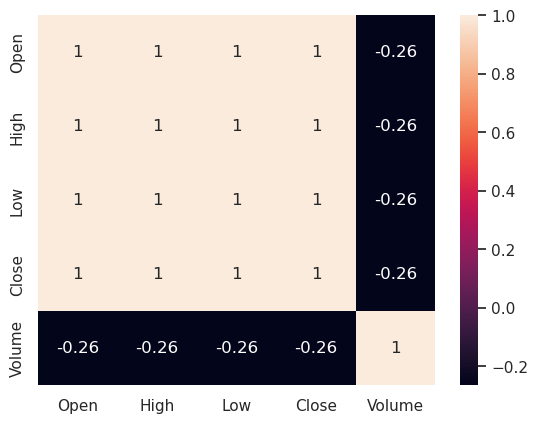

In [49]:
sns.heatmap(correlation,xticklabels = correlation.columns, yticklabels= correlation.columns, annot=True)

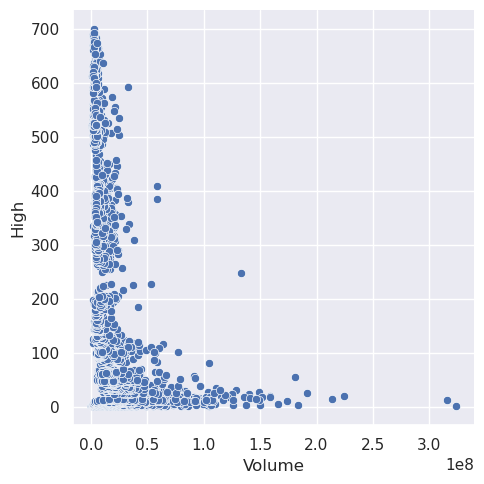

In [50]:
#Just from looking at this there's no correlation between a stock price and volume on itself. 
sns.relplot(data =newData, x='Volume',y= 'High')

Preparing dataset for Modeling

In [26]:
data = df.loc[:,["Open"]].values

train = data[:len(data)-50] 
test = data[len(train):]

In [30]:
# reshape
train=train.reshape(train.shape[0],1)
test=test.reshape(test.shape[0],1)

In [32]:
test.shape

(50, 1)

The training data can be plotted as shown below.

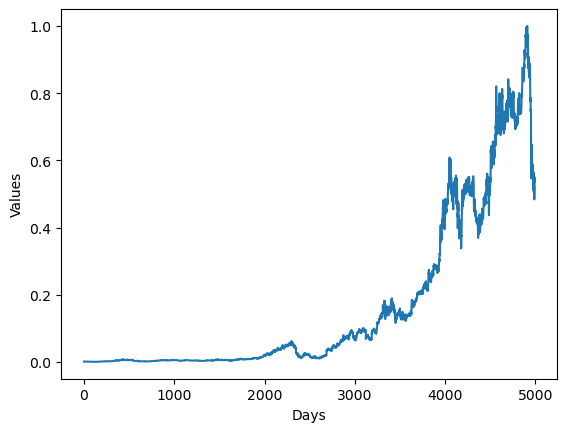

In [33]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0,1)) # defining of Scaler
train_scaled = scaler.fit_transform(train) # applying to Scaler to train

plt.plot(train_scaled)
plt.xlabel("Days")
plt.ylabel("Values")
plt.show()

The data is split as 50 readings are X_train and the 51st will be y_train.

In [35]:
# We add first 50 location to "X_train" and we 51. location to "y_train" .
X_train = []
y_train = []
timesteps = 50

for i in range(timesteps, train_scaled.shape[0]):
    X_train.append(train_scaled[i-timesteps:i,0])
    y_train.append(train_scaled[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)


# Reshaping
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # Dimension of array is 3.

# 2) Models

Here we try different deep learning models for training and testing.

## (a) RNN
A recurrent NN is trained with 50 inputs

In [36]:
# Importing the Keras libraries and packages

from keras.models import Sequential  
from keras.layers import Dense 
from keras.layers import SimpleRNN
from keras.layers import Dropout # it block to overfitting

2023-07-11 13:31:39.069258: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-11 13:31:39.349286: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-11 13:31:39.350956: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-11 13:31:40.879699: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [37]:
# Initialising the RNN
regressor = Sequential()

# Adding the first RNN layer and some Dropout regularisation
regressor.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2)) 

# Adding a second RNN layer and some Dropout regularisation.
regressor.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third RNN layer and some Dropout regularisation. 
regressor.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth RNN layer and some Dropout regularisation.
regressor.add(SimpleRNN(units = 50))
regressor.add(Dropout(0.2))


# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

2023-07-11 13:37:08.380637: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


The RNN model is trained using the data.

In [38]:
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
155/155 [==============================] - 8s 30ms/step - loss: 0.1497
Epoch 2/100
155/155 [==============================] - 4s 27ms/step - loss: 0.0307
Epoch 3/100
155/155 [==============================] - 4s 24ms/step - loss: 0.0164
Epoch 4/100
155/155 [==============================] - 4s 25ms/step - loss: 0.0120
Epoch 5/100
155/155 [==============================] - 4s 26ms/step - loss: 0.0088
Epoch 6/100
155/155 [==============================] - 4s 26ms/step - loss: 0.0072
Epoch 7/100
155/155 [==============================] - 4s 26ms/step - loss: 0.0056
Epoch 8/100
155/155 [==============================] - 4s 26ms/step - loss: 0.0046
Epoch 9/100
155/155 [==============================] - 4s 23ms/step - loss: 0.0040
Epoch 10/100
155/155 [==============================] - 4s 23ms/step - loss: 0.0033
Epoch 11/100
155/155 [==============================] - 4s 25ms/step - loss: 0.0031
Epoch 12/100
155/155 [==============================] - 4s 24ms/step - loss: 0.0028
E

For testing the RNN model, we used the last 50 readings from the data as test data.

In [53]:
inputs = data[len(data) - len(test) - timesteps:]
inputs = scaler.transform(inputs)  # min max scaler

X_test = []
for i in range(timesteps, inputs.shape[0]):
    X_test.append(inputs[i-timesteps:i, 0]) 
X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [54]:
predicted_rnn_data = regressor.predict(X_test)
predicted_rnn_data = scaler.inverse_transform(predicted_rnn_data)

2/2 [==============================] - 0s 20ms/step


The real value and the RNN predicted value on the test data can be plotted as below.

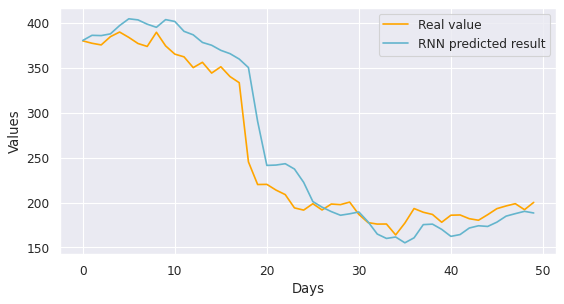

In [55]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test,color="orange",label="Real value")
plt.plot(predicted_rnn_data,color="c",label="RNN predicted result")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Values")
plt.grid(True)
plt.show()

### (b) LSTM

Here we use another Long-Short Term Memory model to check to improve our results.

In [56]:
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error

In [57]:
model = Sequential()
model.add(LSTM(10, input_shape=(None,1))) # We want to add 10 LSTM block. One layer has 10 LSTM unit (node).
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

The LSTM model is trained with 50 epochs.

In [58]:
model.fit(X_train, y_train, epochs=50, batch_size=1)

Epoch 1/50
4944/4944 [==============================] - 56s 11ms/step - loss: 6.6391e-04
Epoch 2/50
4944/4944 [==============================] - 54s 11ms/step - loss: 1.9678e-04
Epoch 3/50
4944/4944 [==============================] - 53s 11ms/step - loss: 1.2712e-04
Epoch 4/50
4944/4944 [==============================] - 53s 11ms/step - loss: 1.0741e-04
Epoch 5/50
4944/4944 [==============================] - 54s 11ms/step - loss: 9.5965e-05
Epoch 6/50
4944/4944 [==============================] - 54s 11ms/step - loss: 9.0288e-05
Epoch 7/50
4944/4944 [==============================] - 54s 11ms/step - loss: 8.8685e-05
Epoch 8/50
4944/4944 [==============================] - 54s 11ms/step - loss: 9.0130e-05
Epoch 9/50
4944/4944 [==============================] - 53s 11ms/step - loss: 8.6449e-05
Epoch 10/50
4944/4944 [==============================] - 53s 11ms/step - loss: 8.9065e-05
Epoch 11/50
4944/4944 [==============================] - 54s 11ms/step - loss: 8.5716e-05
Epoch 12/50
4944/49

In [59]:
predicted_lstm_data=model.predict(X_test)
predicted_lstm_data=scaler.inverse_transform(predicted_lstm_data)

2/2 [==============================] - 0s 5ms/step


The real value and the LSTM predicted value on the test data can be plotted as below.

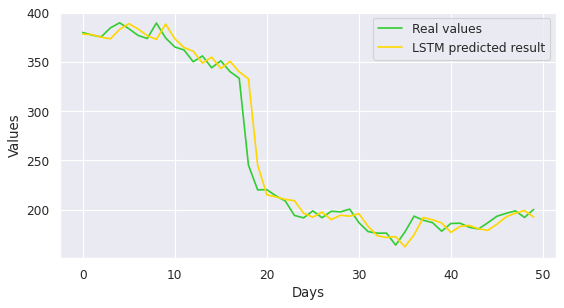

In [60]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test,color="LimeGreen",label="Real values")
plt.plot(predicted_lstm_data,color="Gold",label="LSTM predicted result")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Values")
plt.grid(True)
plt.show()

# 3) Conclusion

We can conclude using the below plots that LSTM is the better model compared to the RNN model.

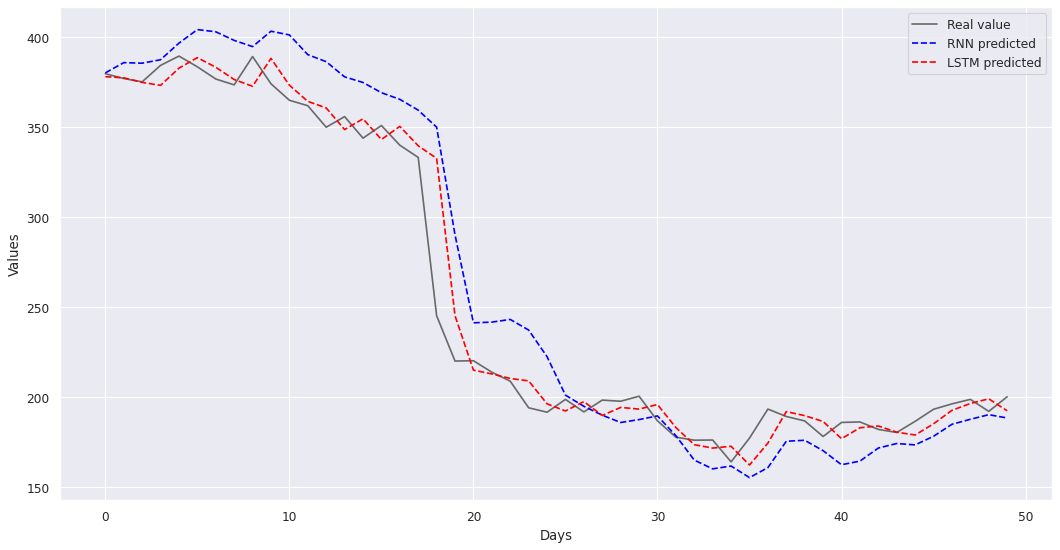

In [61]:
plt.figure(figsize=(16,8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test,color="DimGray",label="Real value")
plt.plot(predicted_rnn_data,color="blue", linestyle="dashed", label="RNN predicted")
plt.plot(predicted_lstm_data,color="red", linestyle="dashed", label="LSTM predicted")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Values")
plt.grid(True)
plt.show()

## If the computational power is good enough to train the models for more epochs, the models may give more accurate predictions.